In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/rock-paper-scissors.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

Data Source : https://www.kaggle.com/drgfreeman/rockpaperscissors

Importing Libraries

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import keras
import keras.backend as K
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

Loading Data

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('/tmp/Rock-Paper-Scissors/train/',
                                                 target_size = (300, 300),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 2520 images belonging to 3 classes.


In [6]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('/tmp/Rock-Paper-Scissors/test/',
                                            target_size = (300, 300),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 372 images belonging to 3 classes.


Transfer Learning with Inception V3

In [19]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [20]:
pre_trained_model = InceptionV3(input_shape = (300, 300, 3),
                                include_top = False,
                                weights = 'imagenet')

87924736/87910968 [==============================] - 2s 0us/step


In [21]:
for layer in pre_trained_model.layers:
  layer.trainable = False  

In [22]:
from tensorflow.keras import layers
from tensorflow.keras import Model

x = layers.Flatten()(pre_trained_model.output)

x = layers.Dense(1024, activation='relu')(x)

x = layers.Dropout(0.2)(x)                  

x = layers.Dense(3, activation='softmax')(x)           

iv3 = Model( pre_trained_model.input, x) 

iv3.compile(optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])

In [23]:
iv3_history = iv3.fit(x= training_set, epochs= 20)

Epoch 1/20
79/79 [==============================] - 54s 605ms/step - loss: 8.9861 - accuracy: 0.9194
Epoch 2/20
79/79 [==============================] - 48s 600ms/step - loss: 0.1517 - accuracy: 0.9940
Epoch 3/20
79/79 [==============================] - 47s 595ms/step - loss: 0.1100 - accuracy: 0.9940
Epoch 4/20
79/79 [==============================] - 47s 598ms/step - loss: 0.0999 - accuracy: 0.9952
Epoch 5/20
79/79 [==============================] - 47s 589ms/step - loss: 0.1284 - accuracy: 0.9944
Epoch 6/20
79/79 [==============================] - 47s 591ms/step - loss: 0.0193 - accuracy: 0.9988
Epoch 7/20
79/79 [==============================] - 47s 594ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/20
79/79 [==============================] - 47s 593ms/step - loss: 0.5772 - accuracy: 0.9833
Epoch 9/20
79/79 [==============================] - 47s 590ms/step - loss: 0.2792 - accuracy: 0.9944
Epoch 10/20
79/79 [==============================] - 49s 614ms/step - loss: 0.1589 - ac

In [34]:
import os
from sklearn.metrics import classification_report,confusion_matrix

path = "/tmp/Rock-Paper-Scissors/test/"

iv3_preds = []
for filename in os.listdir(path):
  new_path = path + filename + "/"
  for img in os.listdir(new_path):
    img_path = new_path + img
    test_image = image.load_img(img_path, target_size = (300, 300))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    test_image /= 255. 
    result = iv3.predict(test_image)
    iv3_preds.append(np.argmax(result[0]))

In [35]:
path = "/tmp/Rock-Paper-Scissors/test/"

value = 0
true_classes = []
for filename in os.listdir(path):
  new_path = path + filename + "/"
  if(filename == "scissors"):
    value = 2
  elif(filename == "rock"):
    value = 1
  else:
    value = 0;
  for img in os.listdir(new_path):
    true_classes.append(value)

Inception V3 Performance

In [36]:
class_labels = list(test_set.class_indices.keys())
report = classification_report(true_classes, iv3_preds, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

       paper       1.00      0.36      0.53       124
        rock       0.66      1.00      0.80       124
    scissors       0.79      0.90      0.84       124

    accuracy                           0.75       372
   macro avg       0.82      0.75      0.72       372
weighted avg       0.82      0.75      0.72       372



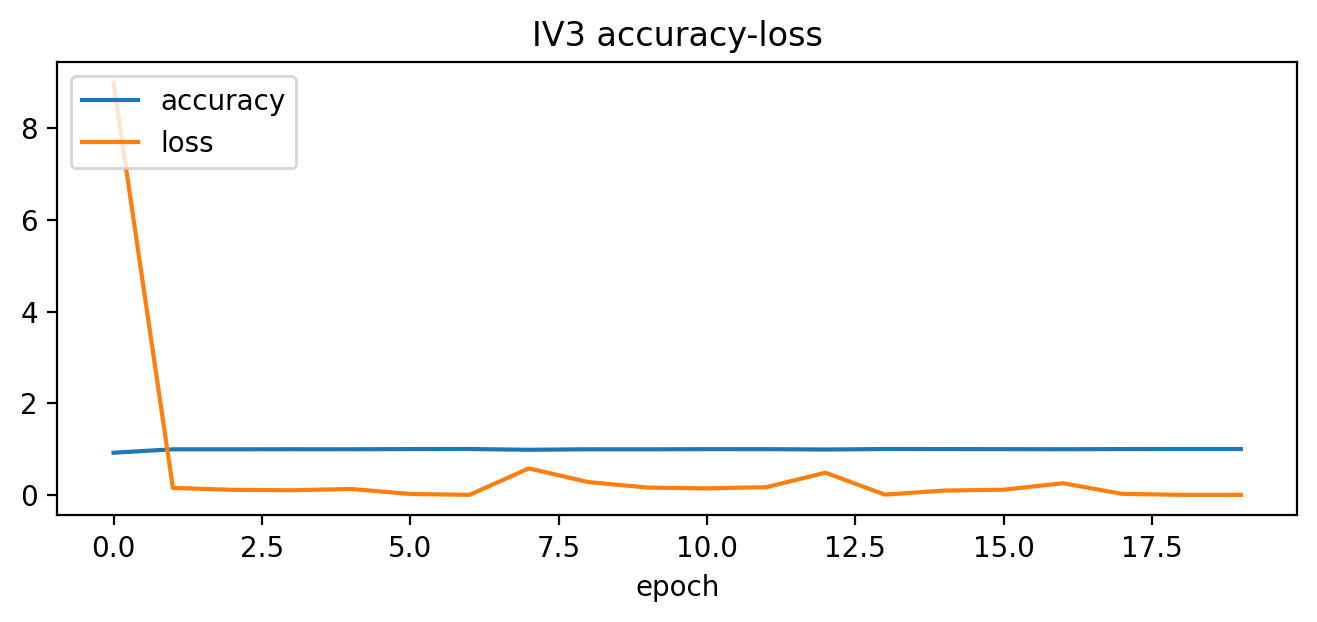

In [33]:
plt.figure(figsize=(8,3),dpi=200)
plt.plot(iv3_history.history['accuracy'])
plt.plot(iv3_history.history['loss'])
plt.title('IV3 accuracy-loss')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

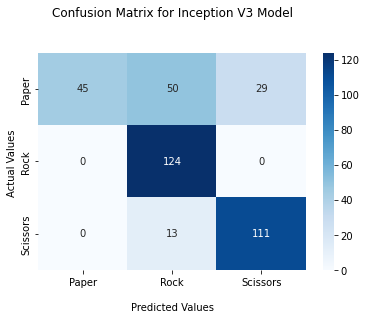

In [37]:
import seaborn as sns
cfmtrx = confusion_matrix(true_classes, iv3_preds)
ax = sns.heatmap(cfmtrx, annot=True, cmap='Blues',fmt='g')


ax.set_title('Confusion Matrix for Inception V3 Model\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['Paper','Rock','Scissors'])
ax.yaxis.set_ticklabels(['Paper','Rock','Scissors'])

plt.show()

Transfer Learning with VGG19

In [38]:
vgg = VGG19(input_shape = (300, 300, 3),
                                include_top = False,
                                weights = 'imagenet')

80150528/80134624 [==============================] - 1s 0us/step


In [39]:
for layer in vgg.layers:
  layer.trainable = False


x = Flatten()(vgg.output) 
prediction = Dense(3, activation='softmax')(x)


vgg19_model = Model(inputs=vgg.input, outputs=prediction)
vgg19_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0   

In [40]:
vgg19_model.compile(optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])

In [41]:
vgg_history = vgg19_model.fit(x= training_set, epochs= 25)

Epoch 1/25
79/79 [==============================] - 58s 660ms/step - loss: 0.3698 - accuracy: 0.9024
Epoch 2/25
79/79 [==============================] - 50s 625ms/step - loss: 0.0098 - accuracy: 0.9988
Epoch 3/25
79/79 [==============================] - 50s 625ms/step - loss: 0.0069 - accuracy: 0.9992
Epoch 4/25
79/79 [==============================] - 51s 638ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 5/25
79/79 [==============================] - 49s 618ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 6/25
79/79 [==============================] - 50s 626ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 7/25
79/79 [==============================] - 50s 624ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 8/25
79/79 [==============================] - 50s 628ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 9/25
79/79 [==============================] - 50s 624ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 10/25
79/79 [==============================] - 49s 622ms/step - loss: 0.0012 - accura

In [42]:
path = "/tmp/Rock-Paper-Scissors/test/"

vgg_preds = []
for filename in os.listdir(path):
  new_path = path + filename + "/"
  for img in os.listdir(new_path):
    img_path = new_path + img
    test_image = image.load_img(img_path, target_size = (300, 300))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    test_image /= 255. 
    result = vgg19_model.predict(test_image)
    vgg_preds.append(np.argmax(result[0]))

VGG19 Performance

In [43]:
report = classification_report(true_classes, vgg_preds, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

       paper       1.00      0.70      0.82       124
        rock       0.70      1.00      0.82       124
    scissors       1.00      0.87      0.93       124

    accuracy                           0.86       372
   macro avg       0.90      0.86      0.86       372
weighted avg       0.90      0.86      0.86       372



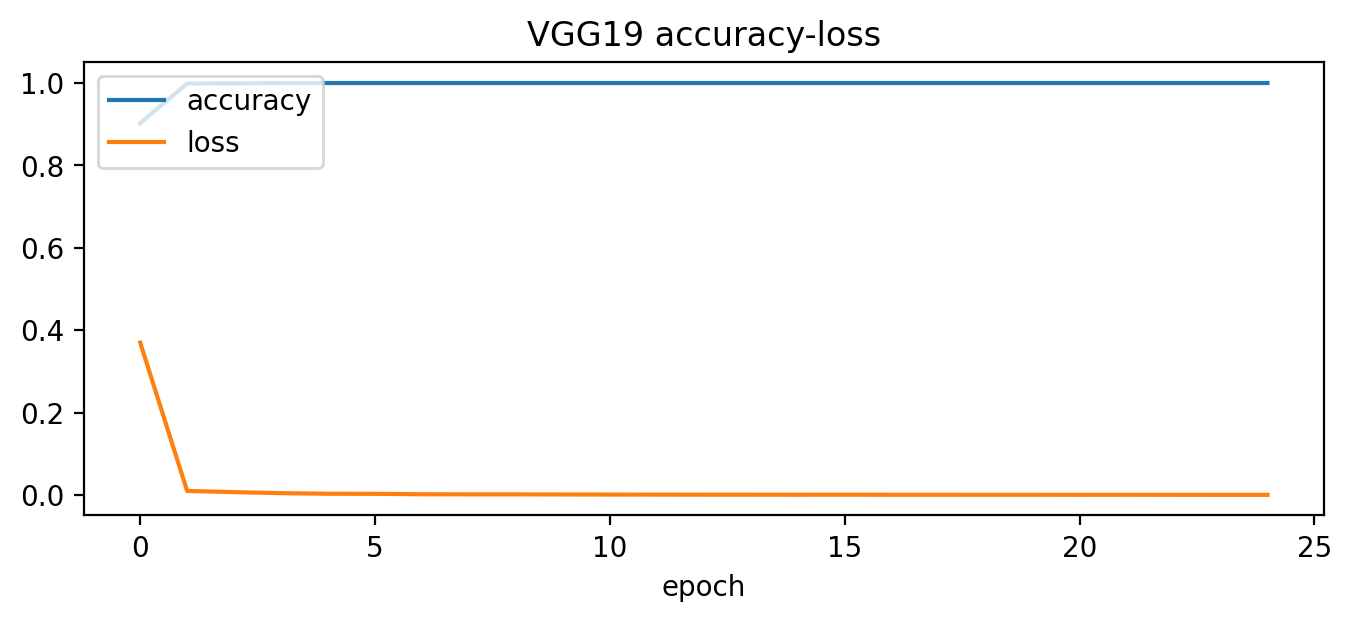

In [44]:
plt.figure(figsize=(8,3),dpi=200)
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['loss'])
plt.title('VGG19 accuracy-loss')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

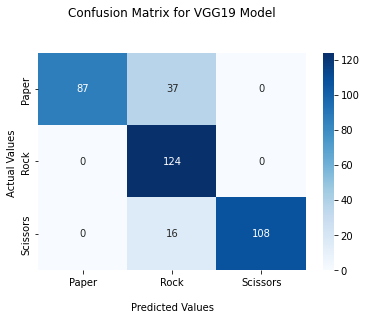

In [45]:
vgg_cfmtrx = confusion_matrix(true_classes, vgg_preds)
ax = sns.heatmap(vgg_cfmtrx, annot=True, cmap='Blues',fmt='g')


ax.set_title('Confusion Matrix for VGG19 Model\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['Paper','Rock','Scissors'])
ax.yaxis.set_ticklabels(['Paper','Rock','Scissors'])

plt.show()